# <center> BOOKING EDA PROJECT

# Постановка задачи

Компания Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля (целевым признаком тут является reviewer_score). Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить!

Первоначальная версия датасета содержит 17 полей со следующей информацией:

* hotel_address — адрес отеля;

* review_date — дата, когда рецензент разместил соответствующий отзыв;

* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;

* hotel_name — название отеля;

* reviewer_nationality — страна рецензента;

* negative_review — отрицательный отзыв, который рецензент дал отелю;

* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;

* positive_review — положительный отзыв, который рецензент дал отелю;

* review_total_positive_word_counts — общее количество слов в положительном отзыве;

* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;

* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;

* total_number_of_reviews — общее количество действительных отзывов об отеле;

* tags — теги, которые рецензент дал отелю;

* days_since_review — количество дней между датой проверки и датой очистки;

* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.

* lat — географическая широта отеля;

* lng — географическая долгота отеля.

In [1]:
# Основные библиотеки
import pandas as pd

# Импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Импортируем необходимые библиотеки для расчетов:
from sklearn.ensemble import RandomForestRegressor # Инструмент для создания и обучения модели
from sklearn import metrics # Инструменты для оценки точности модели
from sklearn.model_selection import train_test_split # Загружаем специальный удобный инструмент для разделения датасета
from sklearn.feature_extraction.text import TfidfVectorizer # Метод для векторизации слов
from sklearn.feature_selection import f_classif # F-тест
from scipy import stats # Библиотека для расчетов
from scipy.stats import mstats # Винсоризация
import category_encoders as ce # библиотека для работы с категориальными признаками

# Импорт из файла applications.py
from applications import get_location_from_api, outliers_iqr_mod_log, extract_tags_info, calculate_distance, analyze_sentiment_cached

from statsmodels.stats.outliers_influence import variance_inflation_factor # Работа с мультиколлинеарностью и статистикой
# Variance Inflation Factor (VIF) — анализ мультиколлинеарности между признаками.
from statsmodels.tools.tools import add_constant # Add_constant — добавление константы для расчета VIF.

import swifter # Для ускорения (параллельного выполнения)
import nltk # Для работы с методом анализа слов

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

# директории с датасетами
DATA_DIR = 'Data/'
df_train = pd.read_csv(DATA_DIR +'hotels_train.csv')
df_test = pd.read_csv(DATA_DIR +'hotels_test.csv')
sample_submission = pd.read_csv(DATA_DIR +'submission.csv')

# Исследование данных

In [3]:
# Наш основной датасет с которым мы будем работать
DATA_SET = df_train

# Просмотр первых и последний строк
display(DATA_SET.head(2))
display(DATA_SET.tail(2))

print()
display('Структура данных')
display(DATA_SET.info())

print()
display('Уникальные признаки')
display(DATA_SET.describe(include='object'))

print()
display('Данные о пропусках в процентах')
missing_procent = round(df_train.isnull().sum() / len(df_train) * 100)
display(missing_procent)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
386801,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,9.2,"[' Leisure trip ', ' Solo traveler ', ' Deluxe...",74 days,51.515125,-0.160066
386802,25 Courtfield Gardens Kensington and Chelsea L...,222,8/5/2016,9.0,The Nadler Kensington,Australia,Patio outside could have been cleaned of alga...,20,1209,Beds comfortable Pillows also good Homely fee...,20,2,8.8,"[' Leisure trip ', ' Couple ', ' Bunk Bed Room...",363 day,51.493109,-0.190208


'Структура данных'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

None

'Уникальные признаки'

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,386803,386803,386803,386803,386803,386803,386803,386803
unique,1493,731,1492,225,248828,311737,47135,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,3587,1911,3587,184033,95907,26885,3853,1911


'Данные о пропусках в процентах'

hotel_address                                 0.0
additional_number_of_scoring                  0.0
review_date                                   0.0
average_score                                 0.0
hotel_name                                    0.0
reviewer_nationality                          0.0
negative_review                               0.0
review_total_negative_word_counts             0.0
total_number_of_reviews                       0.0
positive_review                               0.0
review_total_positive_word_counts             0.0
total_number_of_reviews_reviewer_has_given    0.0
reviewer_score                                0.0
tags                                          0.0
days_since_review                             0.0
lat                                           1.0
lng                                           1.0
dtype: float64

Учитывая, что мы имеем лишь один процент пропусков lat и lng (широта и долгота), стоит в дальнейшем поработать с этими признаками не удалять их.

In [4]:
# Считает дубликаты тренировочной части
mask = df_train.duplicated()
duplicates = df_train[mask]
display(f'Число найденных полных дубликатов (тренировочная часть): {duplicates.shape[0]}')

# Считает дубликаты тестовой части
mask = df_test.duplicated()
duplicates = df_test[mask]
display(f'Число найденных полных дубликатов (тестовая часть): {duplicates.shape[0]}')

'Число найденных полных дубликатов (тренировочная часть): 307'

'Число найденных полных дубликатов (тестовая часть): 29'

In [5]:
# Наш основной датасет
DATA_SET = df_train

# Категориальные признаки
categorial_features = list(DATA_SET.select_dtypes(include='object').columns)
display('Категориальные признаки:')
for i, n in enumerate(categorial_features): 
    display(f'{i+1} - {n}')

print()
# Числовые признаки
numerical_features = list(DATA_SET.select_dtypes(include='number').columns)[:8]
display('Числовые признаки:')
for i, n in enumerate(numerical_features):
    display(f'{i+1} - {n}')

'Категориальные признаки:'

'1 - hotel_address'

'2 - review_date'

'3 - hotel_name'

'4 - reviewer_nationality'

'5 - negative_review'

'6 - positive_review'

'7 - tags'

'8 - days_since_review'

'Числовые признаки:'

'1 - additional_number_of_scoring'

'2 - average_score'

'3 - review_total_negative_word_counts'

'4 - total_number_of_reviews'

'5 - review_total_positive_word_counts'

'6 - total_number_of_reviews_reviewer_has_given'

'7 - reviewer_score'

'8 - lat'

# Подготовка и очистка данных

### Работа с дубликатами

В связи с тем, что были найдены дубликаты в обеих частях датасета мы проведем удаления дубликатов, однако сделать это необходимо только в тренировочной части, т.к. тестовая часть фиксирована и ее изменять нельзя из-за правил соревнования на kaggle.

In [6]:
# Удаляем дубликаты тренировочной части
df_train = df_train.drop_duplicates()

# Проверяем дубликаты после удаления
mask = df_train.duplicated()
duplicates = df_train[mask]
display(f'Число найденных полных дубликатов тренировочной части (после удаления): {duplicates.shape[0]}')

'Число найденных полных дубликатов тренировочной части (после удаления): 0'

### Работа с выбросами (аномалиями)

Далее посмотрим с помощью метода Тьюки количество выбросов в датасете. В ходе выполнения очистки с помощью метода Тьюки выяснялось, что удаляется большое количество данных (до 45 проц.) из тренировочного датасета. В связи с этим буду проводить корректировку выбросов другими способами, например методом Винсоризация.

Винсоризация заменяет выбросы на граничные значения (например, на 5-й и 95-й процентиль). Это позволяет избежать полного удаления данных, сохраняя информацию, но снижая влияние выбросов.

In [7]:
# Делаем оценку выбросов увеличив границы так как данные не распределены нормально
for feature_name in numerical_features:
    outliers, _ = outliers_iqr_mod_log(df_train, feature_name, left=1.5, right=1.5, log_scale=False)
    print()
    print(f'Число выбросов по методу Тьюки в признаке "{feature_name}": [{outliers.shape[0]}]')


Число выбросов по методу Тьюки в признаке "additional_number_of_scoring": [22160]

Число выбросов по методу Тьюки в признаке "average_score": [7137]

Число выбросов по методу Тьюки в признаке "review_total_negative_word_counts": [29304]

Число выбросов по методу Тьюки в признаке "total_number_of_reviews": [19312]

Число выбросов по методу Тьюки в признаке "review_total_positive_word_counts": [27207]

Число выбросов по методу Тьюки в признаке "total_number_of_reviews_reviewer_has_given": [35968]

Число выбросов по методу Тьюки в признаке "reviewer_score": [11885]

Число выбросов по методу Тьюки в признаке "lat": [44973]


### Winsorization (винсоризация) числовых признаков

In [8]:
# Проведем корректировку числовых признаков
for feature_name in numerical_features:
    # Применяем винсоризацию к столбцам
    df_train.loc[:, feature_name] = mstats.winsorize(df_train.loc[:, feature_name], limits=[0.05, 0.05])

### Объединяем тренировочную и тестовые части

In [9]:
# ВАЖНО! для корректной обработки признаков объединяем train и test в один датасет

# Делаем явные копии df_train и df_test, чтобы избежать SettingWithCopyWarning
df_train = df_train.copy()
df_test = df_test.copy()

# Данный признак необходим для того, чтобы по нему в дальнейшем соединить датасет
df_train['sample'] = 1 # помечаем где у нас train
df_test['sample'] = 0 # помечаем где у нас test

# в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['reviewer_score'] = 0 

# Cоединяем
df_hotels = pd.concat([df_test, df_train], sort=False).reset_index(drop=True)

В коде выше возникала ошибка SettingWithCopyWarning, что при изучении выявило несколько проблем в том, что df_train и df_test являлись срезами одного датафрейма, кроме того, в коде присутствовал метод append, который в будущем не будет поддерживаться, вместо него используем pd.concat. Сделаем явные копии "срезов", чтобы избежать ошибки.

### Просмотр объединенного датасета

In [10]:
DATA_SET = df_hotels

# Просмотр первых и последний строк
display(DATA_SET.head(2))
display(DATA_SET.tail(2))

print()
display('Структура данных')
display(DATA_SET.info())

print()
display('Уникальные признаки')
display(DATA_SET.describe(include='object'))

print()
display('Данные о пропусках в процентах')
missing_procent = round(df_train.isnull().sum() / len(df_train) * 100)
display(missing_procent)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
515429,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,26,"[' Leisure trip ', ' Solo traveler ', ' Deluxe...",74 days,51.515125,-0.160066,1,9.2
515430,25 Courtfield Gardens Kensington and Chelsea L...,222,8/5/2016,9.0,The Nadler Kensington,Australia,Patio outside could have been cleaned of alga...,20,1209,Beds comfortable Pillows also good Homely fee...,20,2,"[' Leisure trip ', ' Couple ', ' Bunk Bed Room...",363 day,51.493109,-0.190208,1,8.8


'Структура данных'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

None

'Уникальные признаки'

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,515431,515431,515431,515431,515431,515431,515431,515431
unique,1493,731,1492,227,330011,412601,55242,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,4789,2584,4789,245165,127816,35924,5101,2584


'Данные о пропусках в процентах'

hotel_address                                 0.0
additional_number_of_scoring                  0.0
review_date                                   0.0
average_score                                 0.0
hotel_name                                    0.0
reviewer_nationality                          0.0
negative_review                               0.0
review_total_negative_word_counts             0.0
total_number_of_reviews                       0.0
positive_review                               0.0
review_total_positive_word_counts             0.0
total_number_of_reviews_reviewer_has_given    0.0
reviewer_score                                0.0
tags                                          0.0
days_since_review                             0.0
lat                                           0.0
lng                                           1.0
sample                                        0.0
dtype: float64

In [11]:
# Категориальные признаки
categorial_features = list(df_hotels.select_dtypes(include='object').columns)
display('Категориальные признаки:')
for i, n in enumerate(categorial_features): 
    display(f'{i+1} - {n}')

print()
# Числовые признаки
numerical_features = list(df_hotels.select_dtypes(include='number').columns)[:8]
display('Числовые признаки:')
for i, n in enumerate(numerical_features):
    display(f'{i+1} - {n}')

'Категориальные признаки:'

'1 - hotel_address'

'2 - review_date'

'3 - hotel_name'

'4 - reviewer_nationality'

'5 - negative_review'

'6 - positive_review'

'7 - tags'

'8 - days_since_review'

'Числовые признаки:'

'1 - additional_number_of_scoring'

'2 - average_score'

'3 - review_total_negative_word_counts'

'4 - total_number_of_reviews'

'5 - review_total_positive_word_counts'

'6 - total_number_of_reviews_reviewer_has_given'

'7 - lat'

'8 - lng'

### Отрисовка числовых признаков

Поскольку графиков достаточно много и на их отрисовку уходит много времени мы не будем выводить всю информацию, т.к. в этом нет необходимости. Выборка составляет 40 % от основной массы.

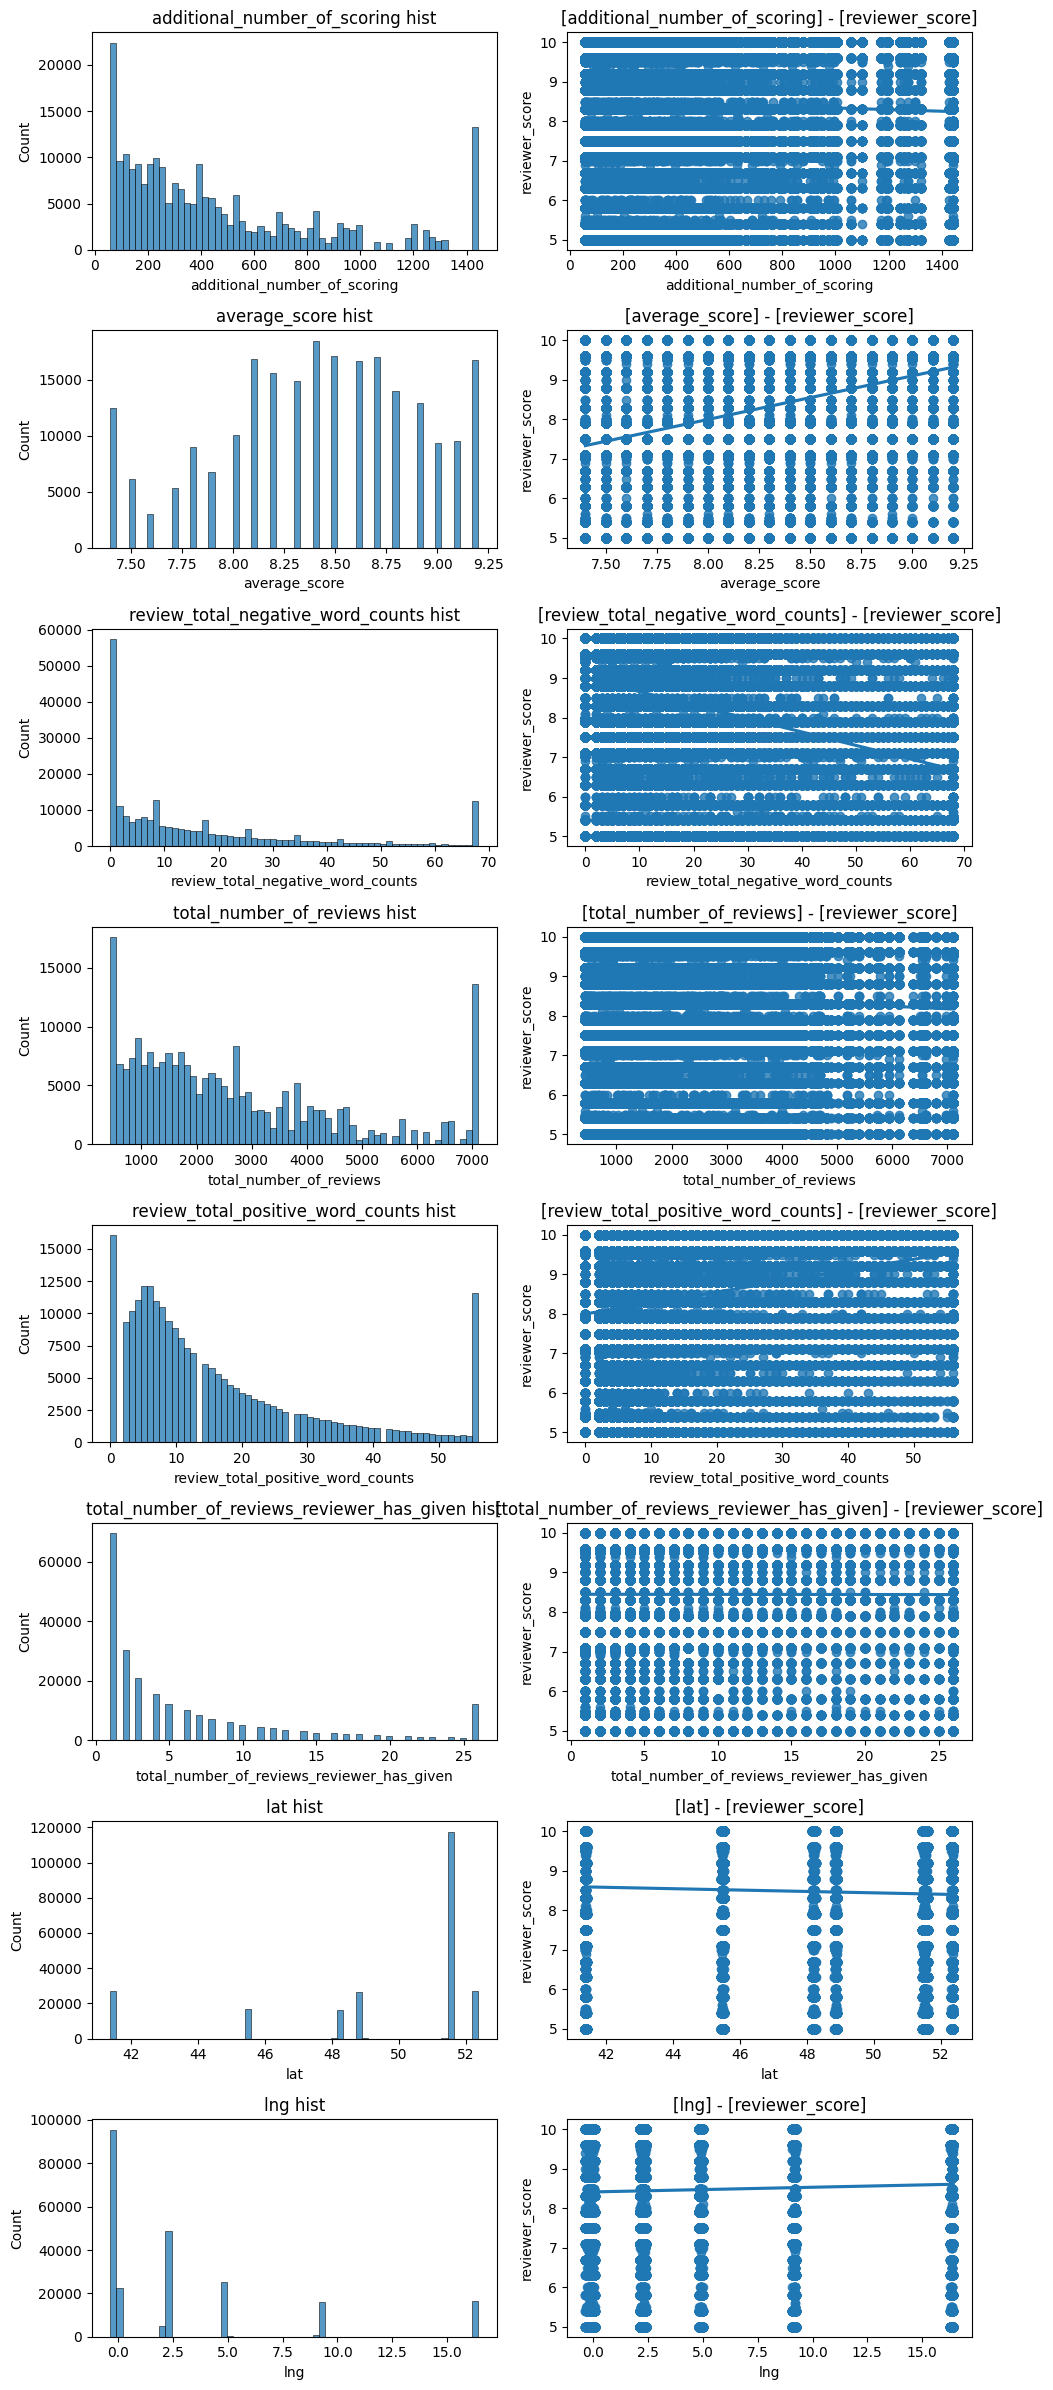

In [12]:
# Отфильтровываем данные только один раз
filtered_data = df_hotels[df_hotels['sample'] == 1] # Тренировочная часть

# Используем 60% данных для построения графиков
sample_size = int(len(filtered_data) * 0.6)
sample_data = filtered_data.sample(n=sample_size, random_state=42)

# Количество числовых признаков
num_of_rows = len(numerical_features)

# Создаем фигуру и набор осей
fig, axes = plt.subplots(num_of_rows, 2, figsize=(10, num_of_rows * 3))  # Динамическое изменение высоты

# Основные числовые признаки
for i, feature in enumerate(numerical_features):
    # Строим гистограмму распределения признака
    sns.histplot(data=sample_data, x=feature, bins=60, ax=axes[i][0]).set_title(f'{feature} hist')
    
    # Строим диаграмму рассеяния и линию регрессии
    sns.regplot(data=sample_data, x=feature, y='reviewer_score', ci=None, ax=axes[i][1]).set_title(f'[{feature}] - [reviewer_score]')

# Плотная компоновка и отображение графиков
plt.tight_layout()
plt.show()

В целом эти признаки распредлены не нормально, кроме average_score. Большинство числовых признаков скошены вправо, с наличием небольших выбросов.
Для некоторых признаков наблюдаются слабые корреляции с целевой переменной reviewer_score. Положительные слова в отзывах коррелируют с высокими оценками, тогда как большое количество негативных слов связано с низкими оценками (коррелируют между собой).

Таким образом стоит обратить особое внимание на два признака:
- review_total_positive_word_counts;
- review_total_negative_word_counts.

In [13]:
print(df_hotels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

### Заполнение пропусков

Примечание: В датасете пропуски обнаружены только в двух признаках расположение отеля: 
- lat (широта);
- lng (долгота).

Для восполнения данных попробуем использовать специализированный API (Google Maps Geocoding API), который по адресу может предоставить координаты.

Примечание: Для использования API необходимо:

1. Регистрация на [сайте сервиса](https://opencagedata.com/);
2. Ограничение на количество запросов в день, примерно 2500 запросов.

In [14]:
# Для начала необходимо отсортировать данные где есть пропуки lat и lng
filtered_data = df_hotels[df_hotels['lat'].isnull() | df_hotels['lng'].isnull()]
print(f"Количество пропусков [lat] и [lng] - {filtered_data['hotel_address'].nunique()}")

Количество пропусков [lat] и [lng] - 17


In [15]:
# Получаем уникальные значения 'hotel_address'
unique_hotel_addresses = filtered_data['hotel_address'].unique()

# Создаем новый DataFrame с уникальными значениями
api_filtered_data = pd.DataFrame(unique_hotel_addresses, columns=['hotel_address'])
api_filtered_data['lat'] = 0  # Добавляем столбец 'lat' с нулями
api_filtered_data['lng'] = 0  # Добавляем столбец 'lng' с нулями

# Записываем новый DataFrame в CSV файл
api_filtered_data.to_csv('Data/api_filtered_data.csv', index=False)

In [16]:
# Прочитаем наш датасет подготовленный для API
api_filtered_data = pd.read_csv('Data/api_filtered_data.csv')
print(api_filtered_data)

                                        hotel_address  lat  lng
0   W hringer Stra e 33 35 09 Alsergrund 1090 Vien...    0    0
1   Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...    0    0
2        23 Rue Damr mont 18th arr 75018 Paris France    0    0
3   Josefst dter Stra e 10 12 08 Josefstadt 1080 V...    0    0
4   Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...    0    0
5   Josefst dter Stra e 22 08 Josefstadt 1080 Vien...    0    0
6           Bail n 4 6 Eixample 08010 Barcelona Spain    0    0
7   Landstra er G rtel 5 03 Landstra e 1030 Vienna...    0    0
8    4 rue de la P pini re 8th arr 75008 Paris France    0    0
9       20 Rue De La Ga t 14th arr 75014 Paris France    0    0
10  W hringer Stra e 12 09 Alsergrund 1090 Vienna ...    0    0
11   Savoyenstra e 2 16 Ottakring 1160 Vienna Austria    0    0
12      Pau Clar s 122 Eixample 08009 Barcelona Spain    0    0
13  Sieveringer Stra e 4 19 D bling 1190 Vienna Au...    0    0
14   Paragonstra e 1 11 Simmering 1110 V

Было принято решение сделать небольшую функцию get_location_from_api, которая обращается к API и получает координаты. Сюда же добавлено количество попыток возобновления соединения при разрыве.

Используем механизм 'секретов' который предоставляет kaggle, т.к. напрямую в коде ключ API не передается!

Примечание: Строки ниже указаны только для платформы KAGGLE!

In [17]:
# # Setup user secrets for login
# from kaggle_secrets import UserSecretsClient

# user_secrets = UserSecretsClient()
# my_api_key = user_secrets.get_secret("Google_Maps_API_KEY") # Label of your New secret

In [18]:
# # Сюда необходимо вставить ваш API ключ после регистрации на сайте
# API_KEY = 'my_api_key'

# # Функция-обертка для обработки адресов
# def process_address(row, API_KEY):
#     time.sleep(1)  # Задержка в 1 секунды
#     latitude, longitude = get_location_from_api(row['hotel_address'], API_KEY)
#     return pd.Series([latitude, longitude], index=['lat', 'lng'])

# # Запись пропущенных значений в датафрейм
# api_filtered_data[['lat', 'lng']] = api_filtered_data.swifter.apply(lambda row: process_address(row, API_KEY), axis=1)

# # Cохраняем датафрейм
# api_filtered_data.to_csv('Data/api_filtered_data.csv', index=False)

In [19]:
# Прочитаем наш датасет подготовленный для API
api_filtered_data = pd.read_csv('Data/api_filtered_data.csv')
print(api_filtered_data)

                                        hotel_address  lat  lng
0   W hringer Stra e 33 35 09 Alsergrund 1090 Vien...    0    0
1   Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...    0    0
2        23 Rue Damr mont 18th arr 75018 Paris France    0    0
3   Josefst dter Stra e 10 12 08 Josefstadt 1080 V...    0    0
4   Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...    0    0
5   Josefst dter Stra e 22 08 Josefstadt 1080 Vien...    0    0
6           Bail n 4 6 Eixample 08010 Barcelona Spain    0    0
7   Landstra er G rtel 5 03 Landstra e 1030 Vienna...    0    0
8    4 rue de la P pini re 8th arr 75008 Paris France    0    0
9       20 Rue De La Ga t 14th arr 75014 Paris France    0    0
10  W hringer Stra e 12 09 Alsergrund 1090 Vienna ...    0    0
11   Savoyenstra e 2 16 Ottakring 1160 Vienna Austria    0    0
12      Pau Clar s 122 Eixample 08009 Barcelona Spain    0    0
13  Sieveringer Stra e 4 19 D bling 1190 Vienna Au...    0    0
14   Paragonstra e 1 11 Simmering 1110 V

Ура! Мы успешно спарсили необходимые данные, теперь можно заполнить ими наши пробелы в основном датасете.

In [20]:
# Соединяем датафреймы, чтобы оставить названия столбцов в основном датасете пишем suffixes=(None, '_api')
df_hotels = df_hotels.merge(api_filtered_data, on='hotel_address', how='left', suffixes=(None, '_api'))

# Заполняем пробелы с помощью метода fillna
df_hotels['lat'] = df_hotels['lat'].fillna(df_hotels['lat_api'])
df_hotels['lng'] = df_hotels['lng'].fillna(df_hotels['lng_api'])

# Удаление ненужных столбцов
df_hotels = df_hotels.drop(columns=['lat_api', 'lng_api'])

Все получилось, пропущенных данных в нашем основном датасете нет, теперь стоит перейти к изучению и созданию новых признаков.

In [21]:
display('Данные о пропусках в процентах')
missing_procent = round(df_hotels.isnull().sum() / len(df_hotels) * 100)
display(missing_procent)

'Данные о пропусках в процентах'

hotel_address                                 0.0
additional_number_of_scoring                  0.0
review_date                                   0.0
average_score                                 0.0
hotel_name                                    0.0
reviewer_nationality                          0.0
negative_review                               0.0
review_total_negative_word_counts             0.0
total_number_of_reviews                       0.0
positive_review                               0.0
review_total_positive_word_counts             0.0
total_number_of_reviews_reviewer_has_given    0.0
tags                                          0.0
days_since_review                             0.0
lat                                           0.0
lng                                           0.0
sample                                        0.0
reviewer_score                                0.0
dtype: float64

# Проектирование новых признаков

Что первым бросается в глаза так это review_date имеющий тип object. Для того, чтобы можно было удобно работать с этим признаком переведем его в тип datetime.

### Работа с признаком review_date

In [22]:
# Преобразуем признак review_date из object в datetime для дальнейших преобразований
df_hotels['review_date'] = pd.to_datetime(df_hotels['review_date'])

Из признака review_date можно выделить несколько новых признаков:
- год;
- месяц;
- день недели (т.к. просто день врядли будет представлять для нас интерес);
- квартал (он же сезон и врямя года).

In [23]:
# Создадим новые признаки:
df_hotels['review_year'] = df_hotels['review_date'].dt.year
df_hotels['review_month'] = df_hotels['review_date'].dt.month
df_hotels['review_day_of_week'] = df_hotels['review_date'].dt.dayofweek
df_hotels['review_quarter'] = df_hotels['review_date'].dt.quarter

# Удаляем теперь бесполезный для нас признак review_date
df_hotels = df_hotels.drop(labels=['review_date'], axis=1)

Далее на очереди признак days_since_review который максимально просто можно обработать и создать из него численный признак убрав строчку days и переведя его в тип int.

### Работа с признаком days_since_review

In [24]:
# Преобразуем признак days_since_review
df_hotels['days_since_review'] = df_hotels['days_since_review'].apply(lambda x: x.split(' ')[0])
df_hotels['days_since_review'] = df_hotels['days_since_review'].astype(int)

На основе days_since_review и признаков negative_review и positive_review можно попробовать создать еще признак:


In [25]:
df_hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 21 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   average_score                               515431 non-null  float64
 3   hotel_name                                  515431 non-null  object 
 4   reviewer_nationality                        515431 non-null  object 
 5   negative_review                             515431 non-null  object 
 6   review_total_negative_word_counts           515431 non-null  int64  
 7   total_number_of_reviews                     515431 non-null  int64  
 8   positive_review                             515431 non-null  object 
 9   review_total_positive_word_counts           515431 non-null  int64  
 

Наступает время снова обратиться к признаку hotel_address для того, чтобы попытаться выделить из него:
- Название страны;
- Город.

### Работа с признаком hotel_address

In [26]:
# Посмотрим как выглядят данные hotel_address и hotel_name
display(df_hotels['hotel_address'][0])

'Via Senigallia 6 20161 Milan Italy'

Прежде всего для дальнейшего парсинга строк стоит привести их все в нижний регистр для упрощения задачи.

In [27]:
# Приводим все hotel_address к нижнему регистру
df_hotels['hotel_address'] = df_hotels['hotel_address'].apply(lambda x: x.lower())

# Проверяем, что получилось
display(df_hotels['hotel_address'].head(2))
display(df_hotels['hotel_address'].tail(2))

0                   via senigallia 6 20161 milan italy
1    arlandaweg 10 westpoort 1043 ew amsterdam neth...
Name: hotel_address, dtype: object

515429    31 great cumberland place westminster borough ...
515430    25 courtfield gardens kensington and chelsea l...
Name: hotel_address, dtype: object

Для парсинга городов и стран можно было бы использовать так же наш API, но это более сложный вариант. К тому же, количество запросов к нему ограничено и займет много времени. Поэтому выбор делается в пользу варианта разбиения строки с использованием метода strip().split().

Примечание: Поскольку оказалось, что в адресах присутствует страна из двух слов, в частности United Kingdom пришлось делать дополнительные проверки.

### Извлекаем название страны

In [28]:
# Функция для извлечения страны из строки адреса
def extract_country(address):
    # Разбиваем строку по пробелам
    address_parts = address.strip().split()
    # Проверяем, содержится ли в конце адреса слово 'kingdom'
    if 'kingdom' not in address:
        country_name = address_parts[-1]
        return country_name
    else:
        # Если в адресе есть 'kingdom', возвращаем последние два элемента как название страны
        country_name = address_parts[-2] + ' ' + address_parts[-1]
        return country_name

# Применяем функцию к каждому адресу
df_hotels['country'] = df_hotels['hotel_address'].swifter.apply(extract_country)

Pandas Apply:   0%|          | 0/515431 [00:00<?, ?it/s]

### Извлекаем название города

In [29]:
# Функция для извлечения города и страны из строки адреса
def extract_city(address):
    # Разбиваем строку по пробелам
    address_parts = address.strip().split()
    # Проверяем, содержится ли в конце адреса слово 'kingdom'
    if 'kingdom' not in address:
        city_name = address_parts[-2]
        return city_name
    else:
        # Если в адресе есть 'kingdom', возвращаем третий элемент как название города
        city_name = address_parts[-5]
        return city_name

# Применяем функцию к каждому адресу
df_hotels['city'] = df_hotels['hotel_address'].swifter.apply(extract_city)

Pandas Apply:   0%|          | 0/515431 [00:00<?, ?it/s]

In [30]:
# Проверка результата
display("Страны:")
display(df_hotels['country'].value_counts())
print()
display("Города:")
display(df_hotels['city'].value_counts())

'Страны:'

country
united kingdom    262300
spain              60149
france             59626
netherlands        57212
austria            38938
italy              37206
Name: count, dtype: int64

'Города:'

city
london       262300
barcelona     60149
paris         59626
amsterdam     57212
vienna        38938
milan         37206
Name: count, dtype: int64

In [31]:
# Удаляем лишние теперь признаки
df_hotels = df_hotels.drop(['hotel_name', 'hotel_address'], axis=1)

Скорее всего отдельные признаки страны и города врядли сильно будут полезны для прогнозирования модели. Можно попытаться из них создать дополнительный признак, например является ли клиент гостинницы местным жителем. 

Условно говоря, если страна гостинницы и страна происхождения клиента совпадают, то клиент местный и его мнению можно доверять в бОльшей степени, хотя это спорное утверждение.

- клиент местный ставим 1;
- клиент иностранец ставим 0.

### Работа с признаком is_reviewer_local

Для начала стоит обратить внимание, что признак с национальностью респондента имеет пробелы, кроме того, ее лучше перевести в нижний регистр для удобства обработки.

In [32]:
# До обработки
display(df_hotels['reviewer_nationality'][0])

# Уберем пробелы и поставим национальность в нижний регистр
df_hotels['reviewer_nationality'] = df_hotels['reviewer_nationality'].swifter.apply(lambda x: x.strip().lower())

# После обработки
display(df_hotels['reviewer_nationality'][0])

' United Kingdom '

Pandas Apply:   0%|          | 0/515431 [00:00<?, ?it/s]

'united kingdom'

In [33]:
# Создадим бинарный признак 'локальности клиента'
df_hotels['is_reviewer_local'] = df_hotels.swifter.apply(lambda x: 1 if x['country'] == x['reviewer_nationality'] else 0, axis=1)

# Проверка
display('Является ли рецензент местным: [1] - да; [0] - нет')
display(df_hotels['is_reviewer_local'].value_counts())

Pandas Apply:   0%|          | 0/515431 [00:00<?, ?it/s]

'Является ли рецензент местным: [1] - да; [0] - нет'

is_reviewer_local
0    337047
1    178384
Name: count, dtype: int64

Из полученного признака (is_reviewer_local) можно уверено сказать, что в основном все рецензенты иностранцы т.е. страна их происхождения и страна нахождения гостиницы не совпадают.

### Работа с признаком city

Далее у нас остался признак города где находится гостиница, попробую выудить из этого признака полезный - расстояние гостиницы (используя координаты) от центра города (используя признак города). Задача не тривиальная!

In [34]:
# Для начала определим, сколько у нас городов в датасете.
display(df_hotels['city'].value_counts())

city
london       262300
barcelona     60149
paris         59626
amsterdam     57212
vienna        38938
milan         37206
Name: count, dtype: int64

Поскольку городов всего 6, можно не использовать API. Я просто найду необходимую информацию в интернете и сделаю словарь.

### Формула Хаверсина

Рассчеты будут производиться по формуле Хаверсина — это способ вычисления расстояния между двумя точками на поверхности сферы по их широте и долготе. Саму функцию я взял в открытых источниках.

In [35]:
# Применяем функцию ко всему DataFrame для создания признака 'distance_to_center'
df_hotels['distance_to_center'] = df_hotels.swifter.apply(calculate_distance, axis=1)

Pandas Apply:   0%|          | 0/515431 [00:00<?, ?it/s]

### Работа с признаками positive_review и negative_review

Cудя по визуализации выше на модель оказывают сильное влияние признаки:
- positive_review;
- negative_review.

С помощью метода, который анализирует тональность текста и возвращает оценку compound (SentimentIntensityAnalyzer), который может быть использован для определения того, насколько позитивен или негативен отзыв. 

Судя по другим ноутбукам, этот метод используется всеми участниками соревнования.

Примечание: Выяснялось, что выполнение этого метода может занять длительное время, поэтому пришлось сделать словарь (кэш) для слов, чтобы ускорить процесс обработки и использовать библиотеку swifter для параллельного выполнения.

### Метод SentimentIntensityAnalyzer()

In [36]:
# import ssl
# # Отключение проверки сертификатов
# ssl._create_default_https_context = ssl._create_unverified_context
nltk.download('vader_lexicon') # Загружаем данные для VADER (если не загружены)

# Применяем анализ тональности с кэшированием
df_hotels['positive_sentiment'] = df_hotels['positive_review'].swifter.apply(analyze_sentiment_cached)
df_hotels['negative_sentiment'] = df_hotels['negative_review'].swifter.apply(analyze_sentiment_cached)

[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>


Pandas Apply:   0%|          | 0/515431 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/515431 [00:00<?, ?it/s]

После проведенного анализа отзывов, оценка MAPE сильно изменилась и стала: 0.1260 это хороший результат по сравнению с предыдущим, однако, стоит дополнительно поработать над этими признаками и создать новые, чтобы улучшить модель предсказаний.

Попробую признак days_since_review объединить с количеством негативных слов, чтобы учитывать изменение восприятия клиента с течением времени. Отзывы с большим количеством негативных слов, написанные недавно, могут иметь большее значение, чем отзывы, написанные давно.

In [37]:
# Создаем новый признак
df_hotels['neg_word_count_per_day'] = df_hotels['review_total_negative_word_counts'] / (df_hotels['days_since_review'] + 1)

### Метод TfidfVectorizer() - Векторизация слов

На данный момент удалось достичь, хороших результатов (MAPE: 0.1095), попробуем применить векторизацию к признакам (negative_review и positive_review).

In [38]:
# Объединяем оба столбца с отзывами для векторизации
df_hotels['all_reviews'] = df_hotels['positive_review'].fillna('') + ' ' + df_hotels['negative_review'].fillna('')

# Создаем объект TF-IDF векторизатора, установим максимальное количество новых признаков в 30
# (можно поробовать поставить больше, но это сильно раздует датасет)
tfidf_vectorizer = TfidfVectorizer(max_features=30, stop_words='english', ngram_range=(1, 2))

# Векторизуем объединенные отзывы
reviews_tfidf = tfidf_vectorizer.fit_transform(df_hotels['all_reviews'])

# Преобразуем разреженную матрицу в DataFrame для удобства
reviews_tfidf_df = pd.DataFrame(reviews_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Добавим префикс 'vect_' к столбцам векторизованных данных (это необходимо, чтобы не создавать дублей столбцов)
reviews_tfidf_df.columns = ['vect_' + col for col in reviews_tfidf_df.columns]

# Объединяем векторизованные данные с исходным DataFrame df_hotels
df_hotels = pd.concat([df_hotels, reviews_tfidf_df], axis=1)

# Удаляем временный столбец
df_hotels.drop(columns=['all_reviews'], inplace=True)

### Работа с признаком tags

Теперь можно поработать с признаком tags. Имеет смысл выделить некоторую информацию из тэгов и преобразовать в ключевые категории, например: 
- тип поездки; 
- продолжительность пребывания;
- c какого устройства был сделан отзыв и т.д.


In [39]:
# Применение функции к столбцу 'tags'
df_hotels[['leisure_trip', 'business_trip', 'couple_flag', 'solo_flag', 'group_flag', 'nights_stayed', 'mobile_flag']] = df_hotels['tags'].swifter.apply(extract_tags_info)

Pandas Apply:   0%|          | 0/515431 [00:00<?, ?it/s]

# Кодирование данных

В нашем датасете присутствуют категориальные признаки, которые можно попробовать кодировать. Например признаки национальности рецензента (reviewer_nationality) и город где находится гостиница.

### Работа с признаком reviewer_nationality

In [40]:
# Посчитаем количество признаков до "бинарной операции"
signs_count_before = df_hotels.shape[1]
display(f'Количество новых признаков до BinaryEncoded: {signs_count_before}')

'Количество новых признаков до BinaryEncoded: 63'

In [41]:
# Закодируем признак 'type' с помощью BinaryEncoder
encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])  # Создаем объект BinaryEncoder и указываем столбец 'reviewer_nationality' для кодирования

# Применяем кодирование к столбцу 'reviewer_nationality' и сохраняем результат в новую переменную encoded_data
encoded_data = encoder.fit_transform(df_hotels['reviewer_nationality'])

# Объединяем оригинальный датафрейм df_hotels с закодированными данными по столбцам
df_hotels = pd.concat([df_hotels, encoded_data], axis=1)

# Посчитаем количество признаков после бинарного кодирования
new_signs_count = df_hotels.shape[1] - signs_count_before

# Выводим результат
print(f'Количество новых признаков после BinaryEncoded: {new_signs_count}')

Количество новых признаков после BinaryEncoded: 8


### Работа с признаком country

Поскольку количество стран в датасете довольно большое и не все страны имеют большое количество гостиниц, то можно выбрать топ 20 стран и закодировать их.

In [42]:
# Вычисляем частоту встречаемости стран
top_30_countries = df_hotels['country'].value_counts().nlargest(20).index

# Создаем новый столбец, где страны вне топ-20 заменяются на 'Other'
df_hotels['top_20_countries'] = df_hotels['country'].apply(lambda x: x if x in top_30_countries else 'Other')

# Проверяем результат
display(df_hotels['top_20_countries'].value_counts())

top_20_countries
united kingdom    262300
spain              60149
france             59626
netherlands        57212
austria            38938
italy              37206
Name: count, dtype: int64

In [43]:
# Посчитаем количество признаков до "бинарной операции"
signs_count_before = df_hotels.shape[1]
display(f'Количество новых признаков до BinaryEncoded: {signs_count_before}')

'Количество новых признаков до BinaryEncoded: 72'

In [44]:
# Закодируем признак 'type' с помощью BinaryEncoder
encoder = ce.BinaryEncoder(cols=['top_20_countries'])  # Создаем объект BinaryEncoder и указываем столбец 'top_20_countries' для кодирования

# Применяем кодирование к столбцу 'top_20_countries' и сохраняем результат в новую переменную encoded_data
encoded_data = encoder.fit_transform(df_hotels['top_20_countries'])

# Объединяем оригинальный датафрейм df_hotels с закодированными данными по столбцам
df_hotels = pd.concat([df_hotels, encoded_data], axis=1)

# Посчитаем количество признаков после бинарного кодирования
new_signs_count = df_hotels.shape[1] - signs_count_before

# Выводим результат
print(f'Количество новых признаков после BinaryEncoded: {new_signs_count}')

Количество новых признаков после BinaryEncoded: 3


### Работа с признаком city

Тоже самое можно проделать с признаком город (city) выбрав 20 самых популяных.

In [45]:
display(df_hotels['city'])

0             milan
1         amsterdam
2         barcelona
3             milan
4         amsterdam
            ...    
515426       london
515427       vienna
515428       london
515429       london
515430       london
Name: city, Length: 515431, dtype: object

In [46]:
# Вычисляем частоту встречаемости стран
top_30_сities = df_hotels['city'].value_counts().nlargest(20).index

# Создаем новый столбец, где страны вне топ-30 заменяются на 'Other'
df_hotels['top_20_cities'] = df_hotels['city'].apply(lambda x: x if x in top_30_сities else 'Other')

# Проверяем результат
display(df_hotels['top_20_cities'].value_counts())

top_20_cities
london       262300
barcelona     60149
paris         59626
amsterdam     57212
vienna        38938
milan         37206
Name: count, dtype: int64

In [47]:
# Посчитаем количество признаков до "бинарной операции"
signs_count_before = df_hotels.shape[1]
display(f'Количество новых признаков до BinaryEncoded: {signs_count_before}')

'Количество новых признаков до BinaryEncoded: 76'

In [48]:
# Закодируем признак 'type' с помощью BinaryEncoder
encoder = ce.BinaryEncoder(cols=['top_20_cities'])  # Создаем объект BinaryEncoder и указываем столбец 'top_20_cities' для кодирования

# Применяем кодирование к столбцу 'top_20_cities' и сохраняем результат в новую переменную encoded_data
encoded_data = encoder.fit_transform(df_hotels['top_20_cities'])

# Объединяем оригинальный датафрейм df_hotels с закодированными данными по столбцам
df_hotels = pd.concat([df_hotels, encoded_data], axis=1)

# Посчитаем количество признаков после бинарного кодирования
new_signs_count = df_hotels.shape[1] - signs_count_before

# Выводим результат
print(f'Количество новых признаков после BinaryEncoded: {new_signs_count}')

Количество новых признаков после BinaryEncoded: 3


In [49]:
# Удаляем признак происхождения рецензента и страну нахождения гостиницы
df_hotels = df_hotels.drop(['country', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'top_20_countries', 'city', 'top_20_cities'], axis=1)

# Отбор признаков

Не стал выводить матрицу визуально, т.к это занимает огромное количество времени и не информативно.

### Матрица корреляции (по Пирсону)
Примечание: Хорошо работает на нормально распределённых данных.

In [50]:
# Фильтруем данные
numerical_df = df_hotels.drop(['sample'], axis=1)

In [51]:
# Вычисляем корреляцию Пирсона для числовых признаков
display(numerical_df.corr(method='pearson'))

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,...,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,top_20_countries_0,top_20_countries_1,top_20_countries_2,top_20_cities_0,top_20_cities_1,top_20_cities_2
additional_number_of_scoring,1.000000,-0.139134,0.035545,0.839633,-0.055807,-0.084837,0.013217,0.327220,-0.310455,-0.045547,...,-0.096249,-0.141474,-0.106538,0.156458,0.206834,-0.236065,-0.409249,0.206834,-0.236065,-0.409249
average_score,-0.139134,1.000000,-0.124219,-0.190430,0.117168,0.039701,-0.013982,-0.087538,0.105092,0.108675,...,0.004557,0.036073,-0.012754,-0.042142,-0.059015,0.097614,0.068077,-0.059015,0.097614,0.068077
review_total_negative_word_counts,0.035545,-0.124219,1.000000,0.040691,0.118500,0.007991,-0.042255,0.016635,-0.023638,-0.151797,...,-0.021550,-0.011463,-0.006296,0.005681,0.004382,-0.005509,-0.030032,0.004382,-0.005509,-0.030032
total_number_of_reviews,0.839633,-0.190430,0.040691,1.000000,-0.033364,-0.031476,0.010415,0.103265,-0.020352,-0.046191,...,-0.030384,-0.052618,-0.016994,0.060567,-0.074838,0.018957,-0.184108,-0.074838,0.018957,-0.184108
review_total_positive_word_counts,-0.055807,0.117168,0.118500,-0.033364,1.000000,0.035612,-0.039035,-0.038374,0.038135,0.033461,...,-0.012611,0.012853,-0.031522,-0.029762,-0.046966,0.052771,0.038401,-0.046966,0.052771,0.038401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
top_20_countries_1,-0.236065,0.097614,-0.005509,0.018957,0.052771,0.045967,-0.009676,-0.403405,0.521071,0.015058,...,0.059651,0.108807,0.111211,-0.134816,-0.649328,1.000000,0.115064,-0.649328,1.000000,0.115064
top_20_countries_2,-0.409249,0.068077,-0.030032,-0.184108,0.038401,0.061658,-0.000134,-0.697819,0.156161,0.006102,...,0.118137,0.182879,0.124336,-0.175873,-0.462589,0.115064,1.000000,-0.462589,0.115064,1.000000
top_20_cities_0,0.206834,-0.059015,0.004382,-0.074838,-0.046966,-0.041903,0.022011,0.483755,-0.294321,-0.009490,...,-0.069978,-0.128729,-0.126251,0.127668,1.000000,-0.649328,-0.462589,1.000000,-0.649328,-0.462589
top_20_cities_1,-0.236065,0.097614,-0.005509,0.018957,0.052771,0.045967,-0.009676,-0.403405,0.521071,0.015058,...,0.059651,0.108807,0.111211,-0.134816,-0.649328,1.000000,0.115064,-0.649328,1.000000,0.115064


### Матрица корреляции (по Спирману)

Примечание: Лучше работает на ненормально распределённых данных.

In [52]:
# Вычисляем корреляцию Спирману для числовых признаков
display(numerical_df.corr(method='spearman'))

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,...,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,top_20_countries_0,top_20_countries_1,top_20_countries_2,top_20_cities_0,top_20_cities_1,top_20_cities_2
additional_number_of_scoring,1.000000,-0.128393,0.049012,0.858484,-0.056793,-0.105419,0.023154,0.416849,-0.386371,-0.026505,...,-0.107078,-0.158806,-0.114095,0.175507,0.162086,-0.198339,-0.492520,0.162086,-0.198339,-0.492520
average_score,-0.128393,1.000000,-0.158296,-0.192068,0.138915,0.041071,-0.013865,-0.086136,0.179438,0.198154,...,0.001724,0.032586,-0.015835,-0.039025,-0.049712,0.086209,0.060366,-0.049712,0.086209,0.060366
review_total_negative_word_counts,0.049012,-0.158296,1.000000,0.051496,0.022748,0.007960,-0.045163,0.035146,-0.050168,-0.265928,...,-0.023130,-0.016925,-0.006173,0.012789,0.011522,-0.013093,-0.041151,0.011522,-0.013093,-0.041151
total_number_of_reviews,0.858484,-0.192068,0.051496,1.000000,-0.039596,-0.038846,0.021477,0.150058,-0.044370,-0.042022,...,-0.033868,-0.060740,-0.019742,0.068035,-0.105518,0.078674,-0.223076,-0.105518,0.078674,-0.223076
review_total_positive_word_counts,-0.056793,0.138915,0.022748,-0.039596,1.000000,0.047199,-0.017713,-0.024451,0.060237,0.175454,...,-0.023998,-0.003209,-0.045859,-0.017994,-0.045487,0.053981,0.033929,-0.045487,0.053981,0.033929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
top_20_countries_1,-0.198339,0.086209,-0.013093,0.078674,0.053981,0.050758,-0.009981,-0.153294,0.563359,0.024976,...,0.059651,0.108807,0.111211,-0.134816,-0.649328,1.000000,0.115064,-0.649328,1.000000,0.115064
top_20_countries_2,-0.492520,0.060366,-0.041151,-0.223076,0.033929,0.080415,-0.001055,-0.728804,0.441589,0.012881,...,0.118137,0.182879,0.124336,-0.175873,-0.462589,0.115064,1.000000,-0.462589,0.115064,1.000000
top_20_cities_0,0.162086,-0.049712,0.011522,-0.105518,-0.045487,-0.050065,0.022136,0.205158,-0.532699,-0.014983,...,-0.069978,-0.128729,-0.126251,0.127668,1.000000,-0.649328,-0.462589,1.000000,-0.649328,-0.462589
top_20_cities_1,-0.198339,0.086209,-0.013093,0.078674,0.053981,0.050758,-0.009981,-0.153294,0.563359,0.024976,...,0.059651,0.108807,0.111211,-0.134816,-0.649328,1.000000,0.115064,-0.649328,1.000000,0.115064


### VIF

Для расчет мультиколлинеарности (помимо матриц) я нашел вариант расчета фактора инфляции дисперсии (Variance Inflation Factor, VIF), который измеряет степень корреляции одного признака с другими признаками. 

VIF показывает, насколько сильно стандартная ошибка коэффициента линейной регрессии увеличивается из-за корреляции с другими признаками.

Шкала VIF:

* VIF = 1: Нет корреляции между данным признаком и другими признаками.
* 1 < VIF ≤ 5: Допустимая корреляция. Признак можно оставить в модели.
* VIF > 5: Мультиколлинеарность на уровне, который может привести к проблемам в модели.
* VIF > 10: Высокий уровень мультиколлинеарности, рекомендуется удаление признака.

Удаление признаков:

* Если VIF > 5, это может быть индикатором необходимости пересмотра признака.
* Если VIF > 10, признак обычно считается слишком коллинеарным, и его удаление может улучшить модель.


In [53]:
# Добавляем константу для расчета VIF
X = add_constant(df_hotels.drop(['sample'], axis=1))

# Вычисляем VIF для каждого признака
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Отображаем результат
# Фильтруем признаки с VIF > 5 для удаления
multicollinearity_features = vif[vif["VIF"] > 5]["Feature"]

# # Теперь константа для расчета VIF нам не нужна, нужны только отобранные признаки
# print(f'Список кандидатов на удаление в связи с высоким уровнем VIF: {feature}')
# for i, feature in enumerate(multicollinearity_features, start=1): print(f'{i} - {feature}')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [54]:
# Удаляем лишние признаки имеющие мультиколлинеарность (по расчетам VIF)
df_hotels = df_hotels.drop(labels=multicollinearity_features[1:], axis=1)

In [55]:
# Категориальные признаки
categorial_features = df_hotels.select_dtypes(include='object').columns
display('Категориальные признаки:')
for i, n in enumerate(list(categorial_features), start=1): 
    display(f'{i} - {n}')

print()
# Числовые признаки
numerical_features = df_hotels.select_dtypes(include='number').columns
display('Числовые признаки:')
for i, n in enumerate(list(numerical_features), start=1):
    display(f'{i} - {n}')

'Категориальные признаки:'

'Числовые признаки:'

'1 - average_score'

'2 - review_total_negative_word_counts'

'3 - review_total_positive_word_counts'

'4 - total_number_of_reviews_reviewer_has_given'

'5 - lng'

'6 - sample'

'7 - reviewer_score'

'8 - review_day_of_week'

'9 - is_reviewer_local'

'10 - distance_to_center'

'11 - positive_sentiment'

'12 - negative_sentiment'

'13 - neg_word_count_per_day'

'14 - vect_bar'

'15 - vect_bathroom'

'16 - vect_bed'

'17 - vect_breakfast'

'18 - vect_clean'

'19 - vect_close'

'20 - vect_comfortable'

'21 - vect_excellent'

'22 - vect_friendly'

'23 - vect_good'

'24 - vect_great'

'25 - vect_helpful'

'26 - vect_hotel'

'27 - vect_just'

'28 - vect_like'

'29 - vect_location'

'30 - vect_lovely'

'31 - vect_negative'

'32 - vect_nice'

'33 - vect_night'

'34 - vect_positive'

'35 - vect_really'

'36 - vect_room'

'37 - vect_rooms'

'38 - vect_service'

'39 - vect_shower'

'40 - vect_small'

'41 - vect_staff'

'42 - vect_station'

'43 - vect_stay'

'44 - couple_flag'

'45 - solo_flag'

'46 - group_flag'

'47 - nights_stayed'

'48 - mobile_flag'

'49 - reviewer_nationality_0'

'50 - reviewer_nationality_1'

'51 - reviewer_nationality_2'

'52 - reviewer_nationality_3'

'53 - reviewer_nationality_4'

'54 - reviewer_nationality_5'

'55 - reviewer_nationality_6'

'56 - reviewer_nationality_7'

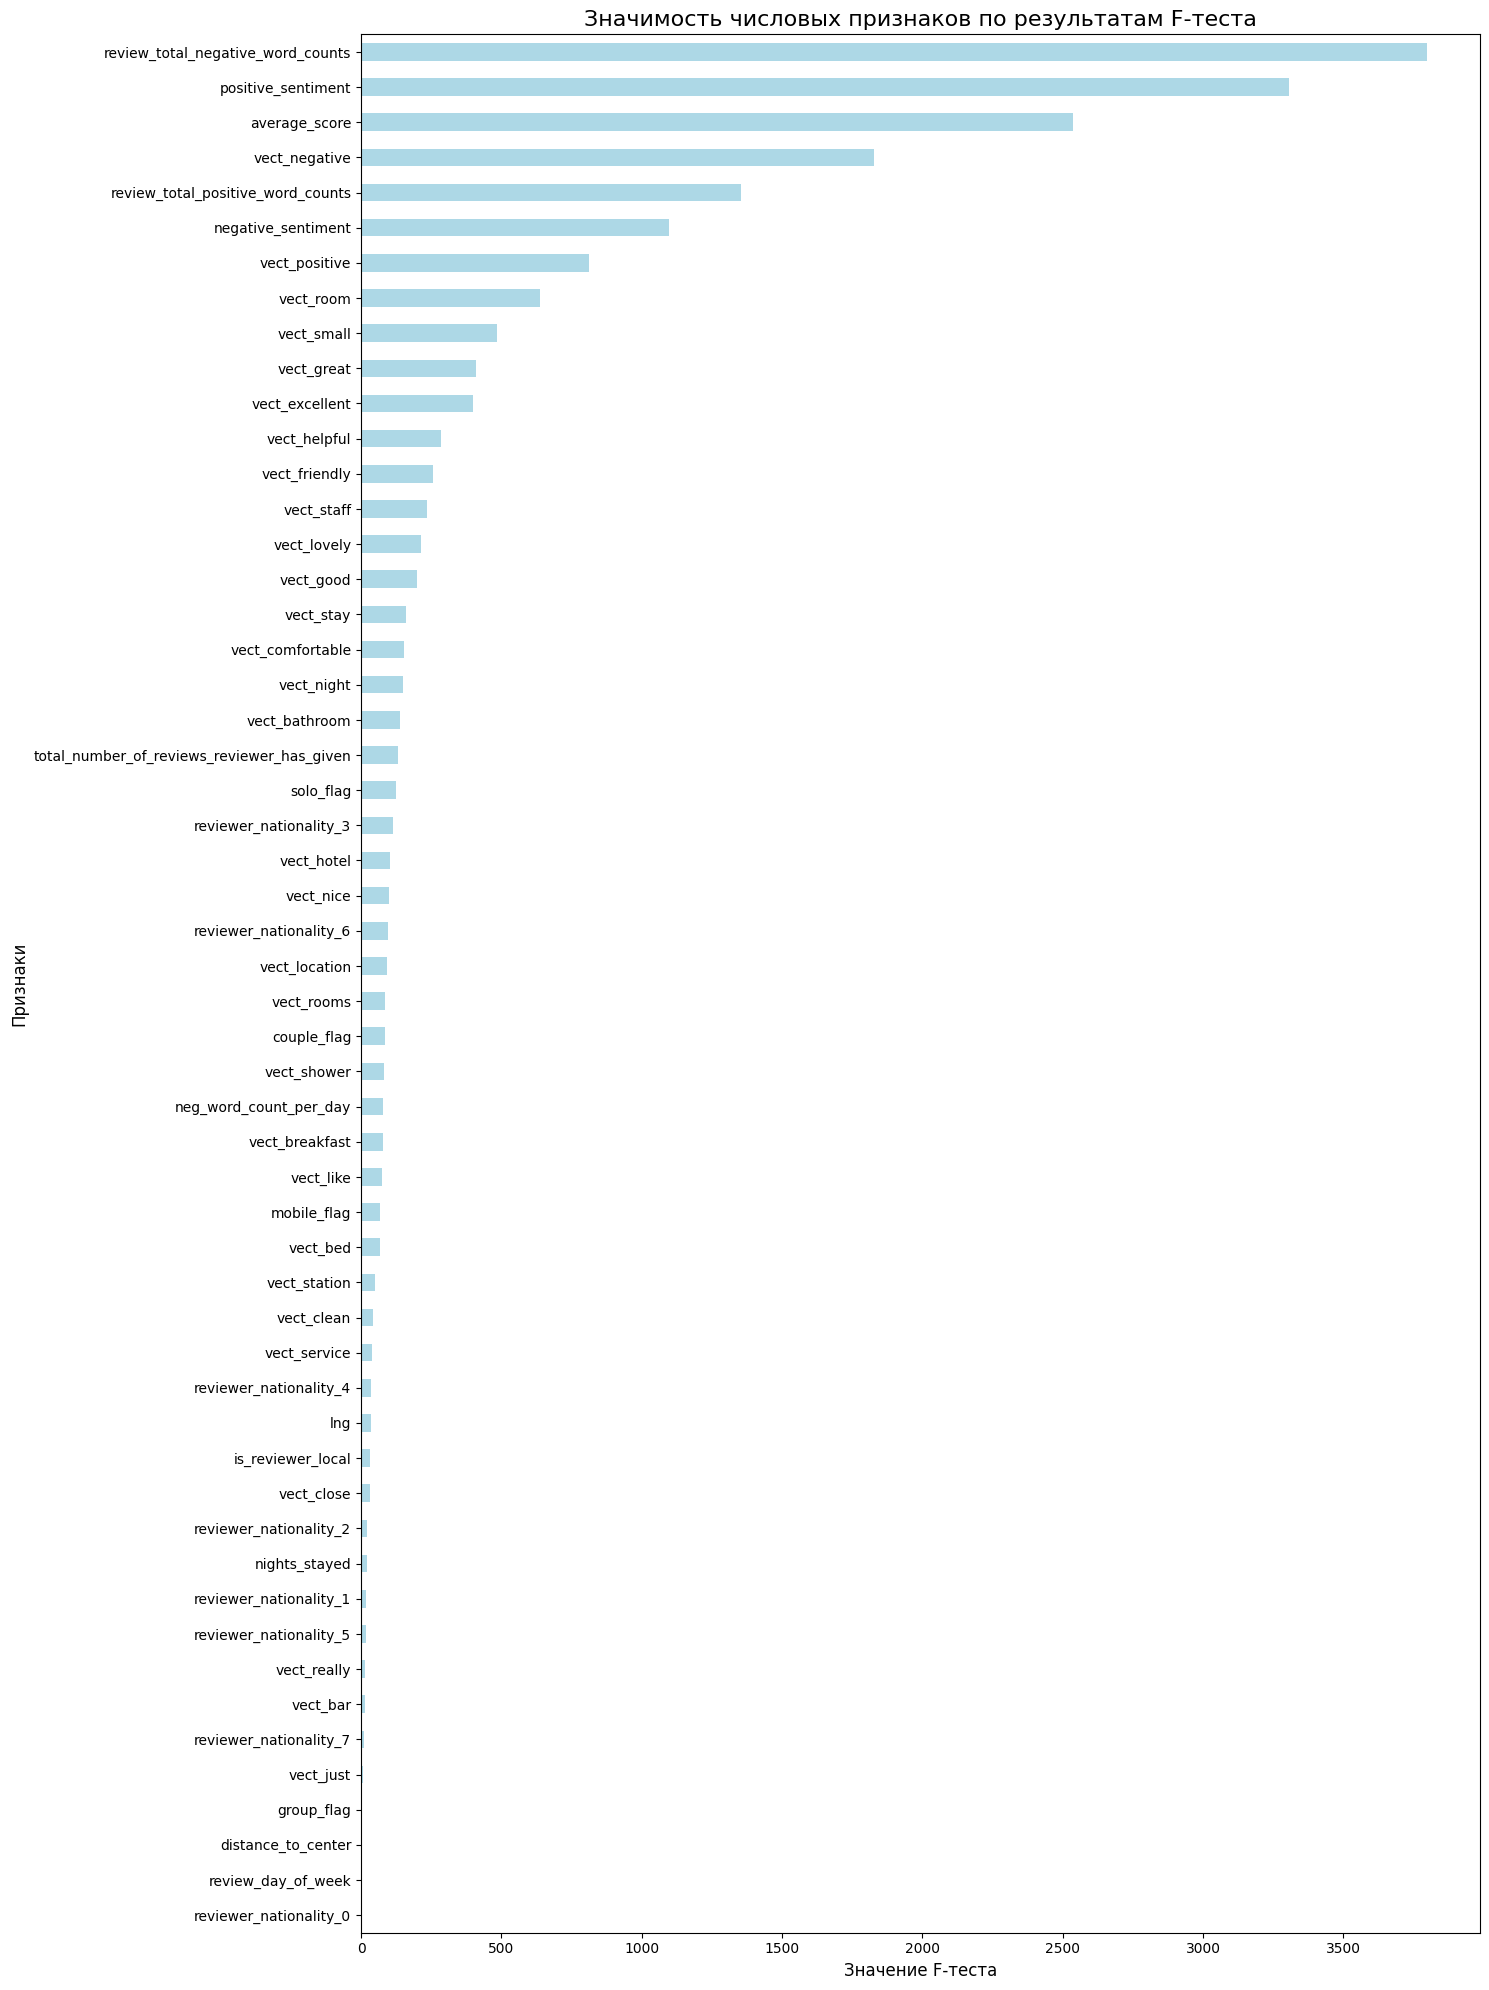

In [56]:
# Для начала создаем копию
df_hotels_selected = df_hotels.copy()

# Получаем целевую переменную y (reviewer_score) из обучающей выборки
y = df_hotels_selected.loc[df_hotels_selected['sample'] == 1, 'reviewer_score'].values
# Получаем обучающие данные X, исключая 'sample' и 'reviewer_score'
X = df_hotels_selected.loc[df_hotels_selected['sample'] == 1].drop(['sample', 'reviewer_score'], axis=1)

# Выполняем ANOVA F-тест для оценки значимости признаков
imp_num = pd.Series(f_classif(X, y)[0], index=X.columns)

# Сортируем признаки по значимости
imp_num.sort_values(inplace=True)

# Визуализация результатов
fig, ax = plt.subplots(figsize=(15, 20))
imp_num.plot(kind='barh', color='lightblue', ax=ax)

# Добавляем подписи
ax.set_title("Значимость числовых признаков по результатам F-теста", fontsize=16)
ax.set_xlabel("Значение F-теста", fontsize=12)
ax.set_ylabel("Признаки", fontsize=12)

# Показываем график
plt.tight_layout()
plt.show()

Далее на основе полученного теста ANOVA удаляем признаки не влияющие на модель.

In [57]:
# Устанавливаем порог значимости (например, удаляем признаки с F-значением ниже 10)
threshold = 10

# Выбираем признаки, которые превышают порог значимости
important_features = imp_num[imp_num > threshold].index

# Добавляем снова признаки 'sample' и 'reviewer_score'!
important_features = important_features.append(pd.Index(['sample', 'reviewer_score']))

# Проверяем список оставшихся признаков
print(f"Количество оставшихся признаков: {len(important_features)}")
print(f"Отобранные признаки:\n{important_features}")

Количество оставшихся признаков: 50
Отобранные признаки:
Index(['vect_bar', 'vect_really', 'reviewer_nationality_5',
       'reviewer_nationality_1', 'nights_stayed', 'reviewer_nationality_2',
       'vect_close', 'is_reviewer_local', 'lng', 'reviewer_nationality_4',
       'vect_service', 'vect_clean', 'vect_station', 'vect_bed', 'mobile_flag',
       'vect_like', 'vect_breakfast', 'neg_word_count_per_day', 'vect_shower',
       'couple_flag', 'vect_rooms', 'vect_location', 'reviewer_nationality_6',
       'vect_nice', 'vect_hotel', 'reviewer_nationality_3', 'solo_flag',
       'total_number_of_reviews_reviewer_has_given', 'vect_bathroom',
       'vect_night', 'vect_comfortable', 'vect_stay', 'vect_good',
       'vect_lovely', 'vect_staff', 'vect_friendly', 'vect_helpful',
       'vect_excellent', 'vect_great', 'vect_small', 'vect_room',
       'vect_positive', 'negative_sentiment',
       'review_total_positive_word_counts', 'vect_negative', 'average_score',
       'positive_sentimen

In [58]:
# Проверяем, чтобы признак 'sample' остался, и отбираем важные признаки вместе с ним
df_hotels_selected = df_hotels_selected[important_features]

# Подготовка модели

In [59]:
# Выделение обучающих и тестовых данных
# Выделяем обучающие данные, где 'sample' == 1 (train) и удаляем колонку 'sample'
train_data = df_hotels_selected.query('sample == 1').drop(['sample'], axis=1)

# Выделяем тестовые данные, где 'sample' == 0 (test) и удаляем колонку 'sample'
test_data = df_hotels_selected.query('sample == 0').drop(['sample'], axis=1)

# Целевая переменная (рейтинги отелей)
y = train_data.reviewer_score.values

# Обучающие данные (все признаки, кроме целевой переменной 'reviewer_score')
X = train_data.drop(['reviewer_score'], axis=1)

# Разделение данных на обучающие и валидационные
# Выделим 20% данных на валидацию (параметр test_size)
split_percent = 0.2

# Воспользуемся функцией train_test_split для разбиения данных на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_percent, random_state=RANDOM_SEED)

# Проверяем размеры выборок
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

# Создание и обучение модели RandomForestRegressor
# Создаем модель RandomForestRegressor
# Параметры: 100 деревьев, многопоточность (-1 для использования всех ядер CPU), фиксированное состояние random_state
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на обучающих данных
model.fit(X_train, y_train)

# Предсказание на валидационной выборке
# Используем обученную модель для предсказания рейтингов на тестовой выборке
y_pred = model.predict(X_test)

# Выбираем случайные 10 строк для просмотра
test_data.sample(10)

# Предсказание на тестовой выборке для отправки на Kaggle
# Удаляем столбец 'reviewer_score' из тестовой выборки, так как это значение мы будем предсказывать
test_data = test_data.drop(['reviewer_score'], axis=1)

# Предсказание на тестовых данных
predict_submission = model.predict(test_data)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.3s finished


<Axes: >

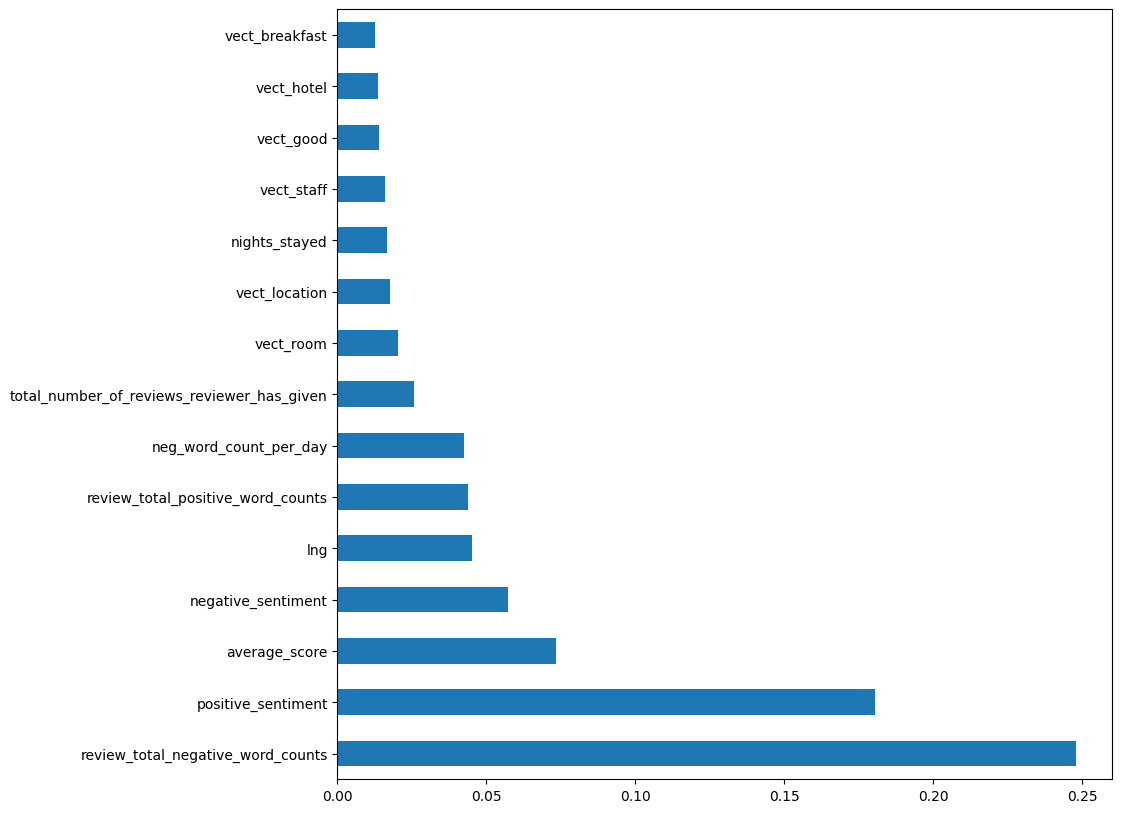

In [60]:
# В RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# MAPE метрика 

In [61]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test) и смотрим, насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную 
# ошибку предсказанных значений в отношении фактических.
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.10648501921677006


# Заключение

In [62]:
# Запись в целевой признак наших расчетов
sample_submission['reviewer_score'] = predict_submission

# Cохраняем результат в датасет
sample_submission.to_csv('Data/submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.434,488440
1,7.697,274649
2,8.837,374688
3,9.807,404352
4,9.711,451596
5,8.965,302161
6,7.947,317079
7,7.723,13963
8,8.673,159785
9,7.547,195089
